# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [16]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

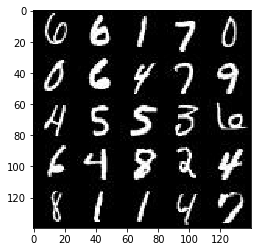

In [17]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

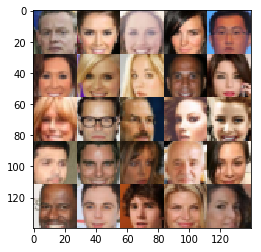

In [18]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [20]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    z_input = tf.placeholder(tf.float32, (None, z_dim))
    learning_rate = tf.placeholder(tf.float32)

    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start\n    handler_func(fd_obj, events)', 'File "/opt/conda/lib/

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [21]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
   
    alpha=0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        
       
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding = 'same')
        x1 = tf.maximum(alpha *x1, x1)
        #14x14x64
        
        x2= tf.layers.conv2d(x1, 128, 5, strides=2, padding ='same')
        x2 = tf.layers.batch_normalization(x2, training = True)
        x2 = tf.maximum(alpha*x2, x2)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training = True)
        x3 = tf.maximum(alpha*x3, x3)
        
        flat = tf.reshape(x3, (-1,4*4*256))
        logits = tf.layers.dense(flat,1)
        out= tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [22]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
     # TODO: Implement Function
    alpha = 0.2    
    with tf.variable_scope('generator', reuse=not is_train):
        
        y1 = tf.layers.dense(z, 7*7*512)
        y1 = tf.reshape(y1, (-1, 7, 7, 512))
        y1 = tf.layers.batch_normalization(y1, training=is_train)
        y1 = tf.maximum(alpha*y1, y1)
        #7x7x512 now
        
        y2 = tf.layers.conv2d_transpose(y1, 256, 5, strides=1, padding = 'same' )
        y2 = tf.layers.batch_normalization(y2, training=is_train)
        y2 = tf.maximum(alpha*y2,y2)
        #7x7x256 now
        
        y3 = tf.layers.conv2d_transpose(y2, 128, 5, strides=2, padding='same')
        y3 = tf.layers.batch_normalization(y3, training= is_train)
        y3 = tf.maximum(alpha*y3, y3)
        #14x14x128 now
        
        logits = tf.layers.conv2d_transpose(y3, out_channel_dim, 5, strides=2, padding ='same')
        
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [23]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse = True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits= d_logits_real,
                                                                        labels = tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits= d_logits_fake,
                                                                        labels = tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits= d_logits_fake, 
                                                                    labels = tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [24]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    train_vars = tf.trainable_variables()
    discriminator_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    generator_vars = [var for var in train_vars if var.name.startswith('generator')]
                                                                       
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=discriminator_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=generator_vars)                                                                  
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [25]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [26]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    _, image_width, image_height, image_channels= data_shape
    input_real, input_z, learnrate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    saver = tf.train.Saver()
    
    #initialize steps 
    steps = 0 
    
    print_every=10
    show_every=100
    
    losses = []
    #samples = [] not required since we have show_generator_output function

    # Since show_n_images = 25, for similarity
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1 
                
                #Mnist images are from -0.5 to 0.5 and our tanh outputs from the generator are from -1 to 1, hence for rescaling
                batch_images *=2.0
                
                
                #sample random noise for G
                batch_z =np.random.uniform(-1,1, size = (batch_size, z_dim))
                
                #run optimizers
                _ = sess.run(d_train_opt, feed_dict = {input_real: batch_images , input_z: batch_z, learnrate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict = {input_real: batch_images , input_z: batch_z, learnrate: learning_rate})
                
                if steps%print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps%show_every == 0:
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode )
       
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4986... Generator Loss: 1.5775
Epoch 1/2... Discriminator Loss: 3.4667... Generator Loss: 0.0460
Epoch 1/2... Discriminator Loss: 1.5102... Generator Loss: 0.4393
Epoch 1/2... Discriminator Loss: 1.1064... Generator Loss: 0.8279
Epoch 1/2... Discriminator Loss: 0.4640... Generator Loss: 2.3765
Epoch 1/2... Discriminator Loss: 1.4862... Generator Loss: 0.5897
Epoch 1/2... Discriminator Loss: 0.9786... Generator Loss: 1.3287
Epoch 1/2... Discriminator Loss: 1.0228... Generator Loss: 1.3963
Epoch 1/2... Discriminator Loss: 1.0286... Generator Loss: 1.3494
Epoch 1/2... Discriminator Loss: 1.1283... Generator Loss: 1.0257


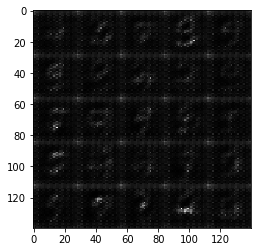

Epoch 1/2... Discriminator Loss: 1.4317... Generator Loss: 0.9311
Epoch 1/2... Discriminator Loss: 1.4907... Generator Loss: 1.3945
Epoch 1/2... Discriminator Loss: 1.1760... Generator Loss: 0.7551
Epoch 1/2... Discriminator Loss: 1.0981... Generator Loss: 0.6030
Epoch 1/2... Discriminator Loss: 0.8686... Generator Loss: 1.0545
Epoch 1/2... Discriminator Loss: 1.2871... Generator Loss: 0.4724
Epoch 1/2... Discriminator Loss: 1.2096... Generator Loss: 1.4672
Epoch 1/2... Discriminator Loss: 1.0320... Generator Loss: 1.3268
Epoch 1/2... Discriminator Loss: 1.1095... Generator Loss: 0.7592
Epoch 1/2... Discriminator Loss: 1.0837... Generator Loss: 0.6619


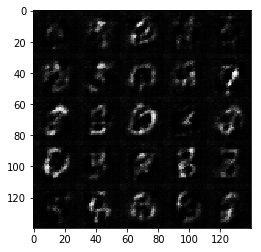

Epoch 1/2... Discriminator Loss: 0.9571... Generator Loss: 0.9934
Epoch 1/2... Discriminator Loss: 1.0008... Generator Loss: 1.8208
Epoch 1/2... Discriminator Loss: 0.8204... Generator Loss: 1.4840
Epoch 1/2... Discriminator Loss: 1.1026... Generator Loss: 1.9342
Epoch 1/2... Discriminator Loss: 0.9821... Generator Loss: 1.2125
Epoch 1/2... Discriminator Loss: 1.3266... Generator Loss: 0.4338
Epoch 1/2... Discriminator Loss: 0.8255... Generator Loss: 1.0410
Epoch 1/2... Discriminator Loss: 0.8699... Generator Loss: 1.5065
Epoch 1/2... Discriminator Loss: 0.9450... Generator Loss: 0.7974
Epoch 1/2... Discriminator Loss: 0.8698... Generator Loss: 1.2948


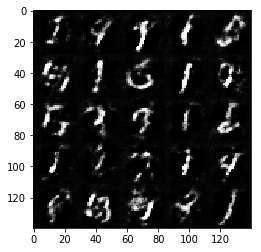

Epoch 1/2... Discriminator Loss: 1.0443... Generator Loss: 0.6010
Epoch 1/2... Discriminator Loss: 0.9607... Generator Loss: 1.5956
Epoch 1/2... Discriminator Loss: 1.0346... Generator Loss: 2.1011
Epoch 1/2... Discriminator Loss: 0.8323... Generator Loss: 1.3795
Epoch 1/2... Discriminator Loss: 0.8709... Generator Loss: 1.2149
Epoch 1/2... Discriminator Loss: 1.0604... Generator Loss: 0.6033
Epoch 1/2... Discriminator Loss: 1.0071... Generator Loss: 0.6926
Epoch 1/2... Discriminator Loss: 1.1258... Generator Loss: 2.0277
Epoch 1/2... Discriminator Loss: 0.9272... Generator Loss: 0.9303
Epoch 1/2... Discriminator Loss: 1.1738... Generator Loss: 2.1680


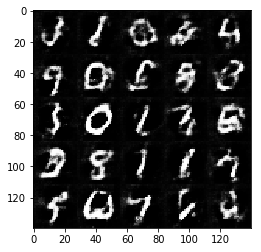

Epoch 1/2... Discriminator Loss: 1.0004... Generator Loss: 1.4405
Epoch 1/2... Discriminator Loss: 0.9516... Generator Loss: 0.9577
Epoch 1/2... Discriminator Loss: 0.9564... Generator Loss: 0.8220
Epoch 1/2... Discriminator Loss: 0.9768... Generator Loss: 0.7129
Epoch 1/2... Discriminator Loss: 0.9845... Generator Loss: 0.9805
Epoch 1/2... Discriminator Loss: 1.3169... Generator Loss: 2.1126
Epoch 2/2... Discriminator Loss: 0.8956... Generator Loss: 1.3221
Epoch 2/2... Discriminator Loss: 0.9804... Generator Loss: 1.1932
Epoch 2/2... Discriminator Loss: 0.9001... Generator Loss: 1.0794
Epoch 2/2... Discriminator Loss: 1.9452... Generator Loss: 0.1962


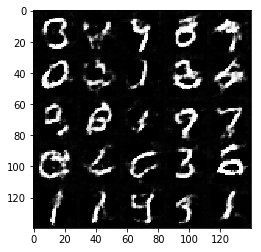

Epoch 2/2... Discriminator Loss: 1.0296... Generator Loss: 0.7985
Epoch 2/2... Discriminator Loss: 0.9471... Generator Loss: 0.8406
Epoch 2/2... Discriminator Loss: 0.9546... Generator Loss: 1.1722
Epoch 2/2... Discriminator Loss: 0.9859... Generator Loss: 1.2258
Epoch 2/2... Discriminator Loss: 0.8990... Generator Loss: 1.0619
Epoch 2/2... Discriminator Loss: 1.1334... Generator Loss: 0.5362
Epoch 2/2... Discriminator Loss: 0.9871... Generator Loss: 0.9712
Epoch 2/2... Discriminator Loss: 1.0552... Generator Loss: 0.6605
Epoch 2/2... Discriminator Loss: 1.1646... Generator Loss: 0.5031
Epoch 2/2... Discriminator Loss: 1.1788... Generator Loss: 0.4921


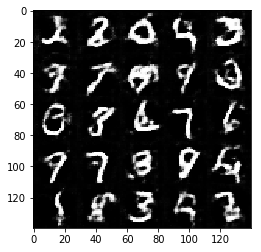

Epoch 2/2... Discriminator Loss: 1.3478... Generator Loss: 0.4046
Epoch 2/2... Discriminator Loss: 1.4001... Generator Loss: 0.3467
Epoch 2/2... Discriminator Loss: 0.9524... Generator Loss: 0.7648
Epoch 2/2... Discriminator Loss: 1.0831... Generator Loss: 0.6295
Epoch 2/2... Discriminator Loss: 0.9587... Generator Loss: 0.9569
Epoch 2/2... Discriminator Loss: 0.9222... Generator Loss: 0.7985
Epoch 2/2... Discriminator Loss: 0.9232... Generator Loss: 0.9812
Epoch 2/2... Discriminator Loss: 0.9146... Generator Loss: 1.0164
Epoch 2/2... Discriminator Loss: 0.8351... Generator Loss: 1.2147
Epoch 2/2... Discriminator Loss: 1.0871... Generator Loss: 0.6262


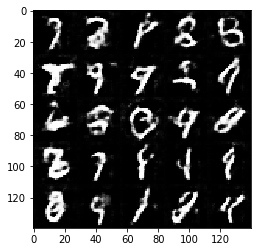

Epoch 2/2... Discriminator Loss: 0.9931... Generator Loss: 0.7238
Epoch 2/2... Discriminator Loss: 0.9379... Generator Loss: 1.3162
Epoch 2/2... Discriminator Loss: 1.6963... Generator Loss: 0.2845
Epoch 2/2... Discriminator Loss: 0.9037... Generator Loss: 0.9196
Epoch 2/2... Discriminator Loss: 0.8672... Generator Loss: 1.1479
Epoch 2/2... Discriminator Loss: 0.9605... Generator Loss: 0.6852
Epoch 2/2... Discriminator Loss: 0.9496... Generator Loss: 1.3933
Epoch 2/2... Discriminator Loss: 0.9569... Generator Loss: 1.3822
Epoch 2/2... Discriminator Loss: 1.8213... Generator Loss: 2.8777
Epoch 2/2... Discriminator Loss: 0.8810... Generator Loss: 0.9220


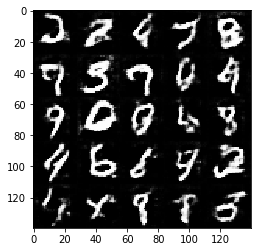

Epoch 2/2... Discriminator Loss: 1.0014... Generator Loss: 0.8277
Epoch 2/2... Discriminator Loss: 0.9888... Generator Loss: 0.7922
Epoch 2/2... Discriminator Loss: 1.0182... Generator Loss: 0.9427
Epoch 2/2... Discriminator Loss: 0.8696... Generator Loss: 1.0986
Epoch 2/2... Discriminator Loss: 0.9726... Generator Loss: 0.7861
Epoch 2/2... Discriminator Loss: 1.1713... Generator Loss: 2.2399
Epoch 2/2... Discriminator Loss: 0.9331... Generator Loss: 0.8245
Epoch 2/2... Discriminator Loss: 0.9883... Generator Loss: 0.7315
Epoch 2/2... Discriminator Loss: 0.8886... Generator Loss: 0.7957
Epoch 2/2... Discriminator Loss: 1.3099... Generator Loss: 0.4038


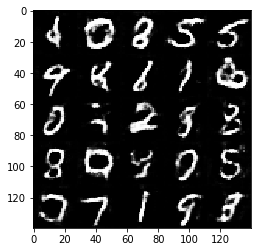

Epoch 2/2... Discriminator Loss: 0.7950... Generator Loss: 1.0627
Epoch 2/2... Discriminator Loss: 1.0225... Generator Loss: 1.6237
Epoch 2/2... Discriminator Loss: 1.0072... Generator Loss: 0.9874


In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.6857... Generator Loss: 0.5000
Epoch 1/1... Discriminator Loss: 0.7648... Generator Loss: 1.1834
Epoch 1/1... Discriminator Loss: 0.9980... Generator Loss: 0.6778
Epoch 1/1... Discriminator Loss: 0.9662... Generator Loss: 0.9026
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 1.1450
Epoch 1/1... Discriminator Loss: 1.4568... Generator Loss: 2.3802
Epoch 1/1... Discriminator Loss: 0.9546... Generator Loss: 1.2639
Epoch 1/1... Discriminator Loss: 0.9975... Generator Loss: 1.2629
Epoch 1/1... Discriminator Loss: 1.1262... Generator Loss: 1.1451
Epoch 1/1... Discriminator Loss: 1.4608... Generator Loss: 1.7390


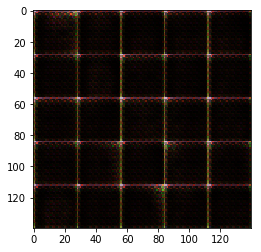

Epoch 1/1... Discriminator Loss: 1.4994... Generator Loss: 0.6398
Epoch 1/1... Discriminator Loss: 1.1330... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 1.0619
Epoch 1/1... Discriminator Loss: 1.1771... Generator Loss: 0.7933
Epoch 1/1... Discriminator Loss: 1.1968... Generator Loss: 0.5717
Epoch 1/1... Discriminator Loss: 1.3603... Generator Loss: 0.8298
Epoch 1/1... Discriminator Loss: 1.7610... Generator Loss: 0.4702
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.8721
Epoch 1/1... Discriminator Loss: 1.2048... Generator Loss: 0.8873
Epoch 1/1... Discriminator Loss: 1.2957... Generator Loss: 0.5482


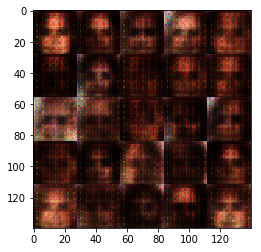

Epoch 1/1... Discriminator Loss: 1.1789... Generator Loss: 0.6463
Epoch 1/1... Discriminator Loss: 1.3354... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 2.0183... Generator Loss: 0.3514
Epoch 1/1... Discriminator Loss: 1.1787... Generator Loss: 0.8833
Epoch 1/1... Discriminator Loss: 1.2615... Generator Loss: 1.1302
Epoch 1/1... Discriminator Loss: 1.1512... Generator Loss: 0.8018
Epoch 1/1... Discriminator Loss: 1.5067... Generator Loss: 1.4094
Epoch 1/1... Discriminator Loss: 1.2218... Generator Loss: 0.9153
Epoch 1/1... Discriminator Loss: 1.2707... Generator Loss: 0.8365


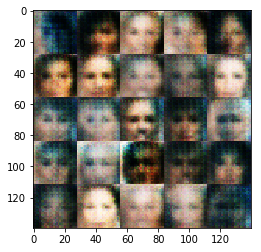

Epoch 1/1... Discriminator Loss: 1.1498... Generator Loss: 1.2392
Epoch 1/1... Discriminator Loss: 1.5559... Generator Loss: 0.5354
Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.6623
Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.6891
Epoch 1/1... Discriminator Loss: 1.5125... Generator Loss: 1.0704
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.7248
Epoch 1/1... Discriminator Loss: 1.4565... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 0.8729
Epoch 1/1... Discriminator Loss: 1.6172... Generator Loss: 0.6520
Epoch 1/1... Discriminator Loss: 1.4917... Generator Loss: 0.6269


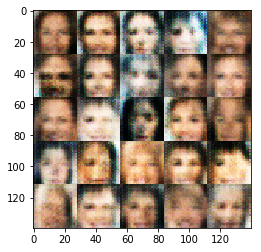

Epoch 1/1... Discriminator Loss: 1.2918... Generator Loss: 0.8233
Epoch 1/1... Discriminator Loss: 1.5533... Generator Loss: 0.7562
Epoch 1/1... Discriminator Loss: 1.2697... Generator Loss: 0.8330
Epoch 1/1... Discriminator Loss: 1.4883... Generator Loss: 0.6507
Epoch 1/1... Discriminator Loss: 1.5966... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.4860... Generator Loss: 0.6742
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.5844
Epoch 1/1... Discriminator Loss: 1.5105... Generator Loss: 0.5817
Epoch 1/1... Discriminator Loss: 1.3109... Generator Loss: 0.8690
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.7763


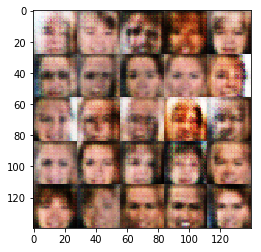

Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.6283
Epoch 1/1... Discriminator Loss: 1.5596... Generator Loss: 0.7306
Epoch 1/1... Discriminator Loss: 1.4682... Generator Loss: 0.6045
Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 1.6217... Generator Loss: 0.5774
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.8977
Epoch 1/1... Discriminator Loss: 1.4863... Generator Loss: 1.0678
Epoch 1/1... Discriminator Loss: 1.3404... Generator Loss: 0.7184
Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 0.8401
Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.7022


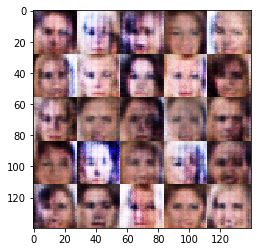

Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 0.7523
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.7092
Epoch 1/1... Discriminator Loss: 1.5015... Generator Loss: 0.8323
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 0.7647
Epoch 1/1... Discriminator Loss: 1.4881... Generator Loss: 0.6323
Epoch 1/1... Discriminator Loss: 1.2161... Generator Loss: 0.8439
Epoch 1/1... Discriminator Loss: 1.5234... Generator Loss: 0.8210
Epoch 1/1... Discriminator Loss: 1.3083... Generator Loss: 0.7488
Epoch 1/1... Discriminator Loss: 1.4570... Generator Loss: 0.7904
Epoch 1/1... Discriminator Loss: 1.2947... Generator Loss: 0.7887


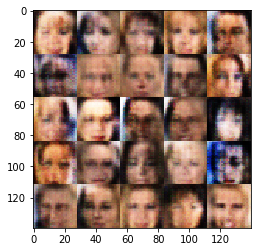

Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.7121
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.7130
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.7564
Epoch 1/1... Discriminator Loss: 1.2391... Generator Loss: 0.9688
Epoch 1/1... Discriminator Loss: 1.5137... Generator Loss: 0.5838
Epoch 1/1... Discriminator Loss: 1.3494... Generator Loss: 0.7340
Epoch 1/1... Discriminator Loss: 1.2571... Generator Loss: 0.8835
Epoch 1/1... Discriminator Loss: 1.5870... Generator Loss: 0.5323
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.7963


In [17]:
batch_size = 256
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

Epoch 1/1... Discriminator Loss: 1.6564... Generator Loss: 0.4318
Epoch 1/1... Discriminator Loss: 1.5419... Generator Loss: 0.4771
Epoch 1/1... Discriminator Loss: 0.8125... Generator Loss: 1.0153
Epoch 1/1... Discriminator Loss: 0.6521... Generator Loss: 5.3818
Epoch 1/1... Discriminator Loss: 1.4673... Generator Loss: 0.8448
Epoch 1/1... Discriminator Loss: 0.8055... Generator Loss: 1.1915
Epoch 1/1... Discriminator Loss: 1.2966... Generator Loss: 2.4334
Epoch 1/1... Discriminator Loss: 1.1281... Generator Loss: 0.7321
Epoch 1/1... Discriminator Loss: 0.8054... Generator Loss: 1.5046
Epoch 1/1... Discriminator Loss: 0.8178... Generator Loss: 1.0116


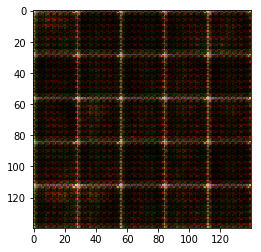

Epoch 1/1... Discriminator Loss: 1.2498... Generator Loss: 1.9827
Epoch 1/1... Discriminator Loss: 1.8662... Generator Loss: 0.2584
Epoch 1/1... Discriminator Loss: 1.0955... Generator Loss: 0.8660
Epoch 1/1... Discriminator Loss: 1.3325... Generator Loss: 0.5028
Epoch 1/1... Discriminator Loss: 1.1724... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.7145
Epoch 1/1... Discriminator Loss: 1.1767... Generator Loss: 1.4196
Epoch 1/1... Discriminator Loss: 1.5414... Generator Loss: 0.4083
Epoch 1/1... Discriminator Loss: 1.1348... Generator Loss: 0.7530
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.4802


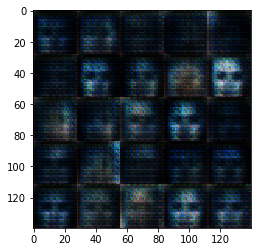

Epoch 1/1... Discriminator Loss: 1.5263... Generator Loss: 0.4219
Epoch 1/1... Discriminator Loss: 1.0760... Generator Loss: 1.0105
Epoch 1/1... Discriminator Loss: 1.3318... Generator Loss: 0.6419
Epoch 1/1... Discriminator Loss: 1.7939... Generator Loss: 1.3386
Epoch 1/1... Discriminator Loss: 0.9984... Generator Loss: 1.0199
Epoch 1/1... Discriminator Loss: 1.2240... Generator Loss: 0.8310
Epoch 1/1... Discriminator Loss: 1.8706... Generator Loss: 0.3384
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.5594
Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 0.5099
Epoch 1/1... Discriminator Loss: 1.2870... Generator Loss: 0.5668


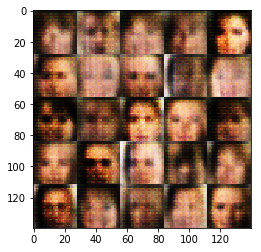

Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.7458
Epoch 1/1... Discriminator Loss: 1.2425... Generator Loss: 0.6042
Epoch 1/1... Discriminator Loss: 1.6312... Generator Loss: 0.6146
Epoch 1/1... Discriminator Loss: 1.2574... Generator Loss: 0.8205
Epoch 1/1... Discriminator Loss: 1.4743... Generator Loss: 0.4979
Epoch 1/1... Discriminator Loss: 1.0416... Generator Loss: 0.8717
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 1.1610... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 1.7711... Generator Loss: 0.4746
Epoch 1/1... Discriminator Loss: 1.3056... Generator Loss: 0.7111


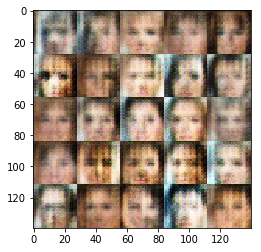

Epoch 1/1... Discriminator Loss: 1.1163... Generator Loss: 0.8155
Epoch 1/1... Discriminator Loss: 1.4636... Generator Loss: 0.5349
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6121
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.8862
Epoch 1/1... Discriminator Loss: 1.5035... Generator Loss: 0.4605
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.9146
Epoch 1/1... Discriminator Loss: 1.3169... Generator Loss: 0.8133
Epoch 1/1... Discriminator Loss: 1.5358... Generator Loss: 0.4438
Epoch 1/1... Discriminator Loss: 1.3015... Generator Loss: 0.6847
Epoch 1/1... Discriminator Loss: 1.4539... Generator Loss: 0.6873


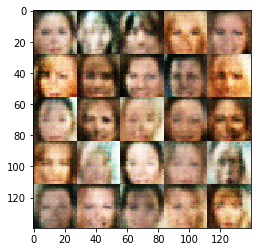

Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 1.0087
Epoch 1/1... Discriminator Loss: 1.2737... Generator Loss: 0.6946
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.5405
Epoch 1/1... Discriminator Loss: 1.3327... Generator Loss: 0.6004
Epoch 1/1... Discriminator Loss: 1.5075... Generator Loss: 0.5969
Epoch 1/1... Discriminator Loss: 1.2966... Generator Loss: 0.7851
Epoch 1/1... Discriminator Loss: 1.2865... Generator Loss: 0.7439
Epoch 1/1... Discriminator Loss: 1.3274... Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.6039
Epoch 1/1... Discriminator Loss: 1.2512... Generator Loss: 1.0285


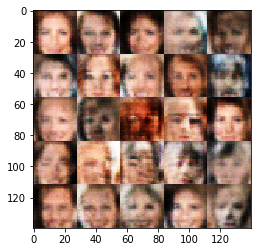

Epoch 1/1... Discriminator Loss: 1.3124... Generator Loss: 0.8777
Epoch 1/1... Discriminator Loss: 1.3141... Generator Loss: 0.6328
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.7557
Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 0.5851
Epoch 1/1... Discriminator Loss: 1.4740... Generator Loss: 0.7836
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.9968
Epoch 1/1... Discriminator Loss: 1.2957... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.8077
Epoch 1/1... Discriminator Loss: 1.3517... Generator Loss: 0.6740
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.7091


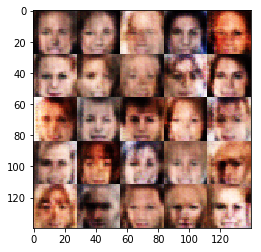

Epoch 1/1... Discriminator Loss: 1.2294... Generator Loss: 0.7864
Epoch 1/1... Discriminator Loss: 1.2774... Generator Loss: 0.5969
Epoch 1/1... Discriminator Loss: 1.1344... Generator Loss: 0.8395
Epoch 1/1... Discriminator Loss: 1.2062... Generator Loss: 0.7466
Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 0.5800
Epoch 1/1... Discriminator Loss: 1.5870... Generator Loss: 0.4273
Epoch 1/1... Discriminator Loss: 1.3031... Generator Loss: 0.7538
Epoch 1/1... Discriminator Loss: 1.2727... Generator Loss: 0.6653
Epoch 1/1... Discriminator Loss: 1.2300... Generator Loss: 0.8298
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.6970


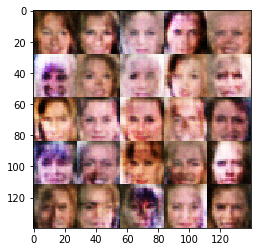

Epoch 1/1... Discriminator Loss: 1.2747... Generator Loss: 0.7860
Epoch 1/1... Discriminator Loss: 1.2311... Generator Loss: 0.8114
Epoch 1/1... Discriminator Loss: 1.2479... Generator Loss: 0.8377
Epoch 1/1... Discriminator Loss: 1.1689... Generator Loss: 0.8813
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.6459
Epoch 1/1... Discriminator Loss: 1.3331... Generator Loss: 0.7609
Epoch 1/1... Discriminator Loss: 1.3162... Generator Loss: 1.1299
Epoch 1/1... Discriminator Loss: 1.3056... Generator Loss: 0.7597
Epoch 1/1... Discriminator Loss: 1.1008... Generator Loss: 0.8342
Epoch 1/1... Discriminator Loss: 1.1056... Generator Loss: 0.7714


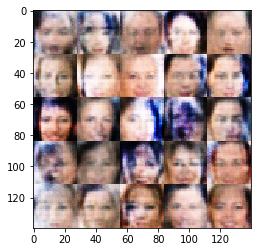

Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.6316
Epoch 1/1... Discriminator Loss: 1.2450... Generator Loss: 0.6659
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.5500
Epoch 1/1... Discriminator Loss: 1.2724... Generator Loss: 0.5958
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.6709
Epoch 1/1... Discriminator Loss: 1.6806... Generator Loss: 0.4261
Epoch 1/1... Discriminator Loss: 1.2266... Generator Loss: 0.6654
Epoch 1/1... Discriminator Loss: 1.3161... Generator Loss: 1.0189
Epoch 1/1... Discriminator Loss: 1.2812... Generator Loss: 0.8883


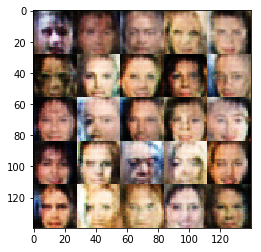

Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 0.6271
Epoch 1/1... Discriminator Loss: 1.2377... Generator Loss: 0.7887
Epoch 1/1... Discriminator Loss: 1.2182... Generator Loss: 1.0240
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.7080
Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.2639... Generator Loss: 1.1056
Epoch 1/1... Discriminator Loss: 1.3105... Generator Loss: 0.7156
Epoch 1/1... Discriminator Loss: 1.1759... Generator Loss: 0.9136
Epoch 1/1... Discriminator Loss: 0.9966... Generator Loss: 0.8856
Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 0.7223


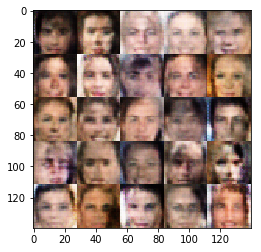

Epoch 1/1... Discriminator Loss: 1.1419... Generator Loss: 1.0320
Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 0.6018
Epoch 1/1... Discriminator Loss: 1.2205... Generator Loss: 0.7136
Epoch 1/1... Discriminator Loss: 1.0326... Generator Loss: 0.7643
Epoch 1/1... Discriminator Loss: 1.2483... Generator Loss: 1.0702
Epoch 1/1... Discriminator Loss: 1.2658... Generator Loss: 1.1467
Epoch 1/1... Discriminator Loss: 1.2604... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 1.2427... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 1.2716... Generator Loss: 0.5478


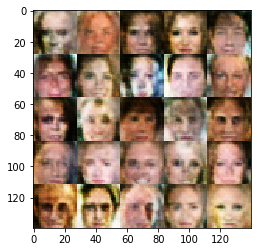

Epoch 1/1... Discriminator Loss: 1.3388... Generator Loss: 0.5854
Epoch 1/1... Discriminator Loss: 1.1355... Generator Loss: 0.9649
Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 0.7222
Epoch 1/1... Discriminator Loss: 1.0747... Generator Loss: 0.9605
Epoch 1/1... Discriminator Loss: 1.2566... Generator Loss: 0.6561
Epoch 1/1... Discriminator Loss: 1.3179... Generator Loss: 0.6727
Epoch 1/1... Discriminator Loss: 1.1340... Generator Loss: 0.7970
Epoch 1/1... Discriminator Loss: 1.2302... Generator Loss: 0.5328
Epoch 1/1... Discriminator Loss: 1.6333... Generator Loss: 0.4226
Epoch 1/1... Discriminator Loss: 1.1346... Generator Loss: 1.0109


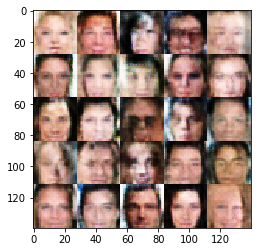

Epoch 1/1... Discriminator Loss: 1.5070... Generator Loss: 0.9224
Epoch 1/1... Discriminator Loss: 1.1411... Generator Loss: 0.9045
Epoch 1/1... Discriminator Loss: 1.2354... Generator Loss: 0.7312
Epoch 1/1... Discriminator Loss: 1.2406... Generator Loss: 0.9647
Epoch 1/1... Discriminator Loss: 1.3389... Generator Loss: 0.8120
Epoch 1/1... Discriminator Loss: 1.3329... Generator Loss: 0.8221
Epoch 1/1... Discriminator Loss: 1.3123... Generator Loss: 0.6841
Epoch 1/1... Discriminator Loss: 1.3389... Generator Loss: 0.6622
Epoch 1/1... Discriminator Loss: 1.3488... Generator Loss: 0.8214
Epoch 1/1... Discriminator Loss: 1.2295... Generator Loss: 0.9431


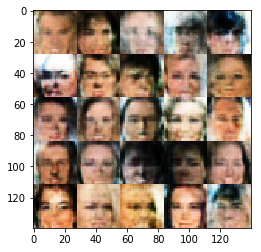

Epoch 1/1... Discriminator Loss: 1.1740... Generator Loss: 0.7806
Epoch 1/1... Discriminator Loss: 1.2705... Generator Loss: 0.6068
Epoch 1/1... Discriminator Loss: 1.1380... Generator Loss: 0.8435
Epoch 1/1... Discriminator Loss: 1.0162... Generator Loss: 0.9559
Epoch 1/1... Discriminator Loss: 1.0890... Generator Loss: 0.9189
Epoch 1/1... Discriminator Loss: 1.4830... Generator Loss: 0.4276
Epoch 1/1... Discriminator Loss: 1.1209... Generator Loss: 0.9035
Epoch 1/1... Discriminator Loss: 1.2638... Generator Loss: 0.9044
Epoch 1/1... Discriminator Loss: 1.4816... Generator Loss: 0.4683
Epoch 1/1... Discriminator Loss: 1.3552... Generator Loss: 0.6506


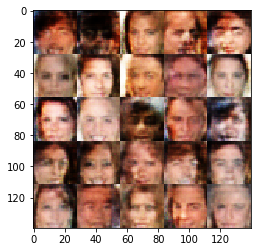

Epoch 1/1... Discriminator Loss: 1.1623... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.2068... Generator Loss: 0.7749
Epoch 1/1... Discriminator Loss: 1.1247... Generator Loss: 0.8241
Epoch 1/1... Discriminator Loss: 1.2708... Generator Loss: 0.7894
Epoch 1/1... Discriminator Loss: 1.1776... Generator Loss: 1.1407
Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 0.5994
Epoch 1/1... Discriminator Loss: 1.2583... Generator Loss: 0.7355
Epoch 1/1... Discriminator Loss: 1.0327... Generator Loss: 0.9978
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.6133
Epoch 1/1... Discriminator Loss: 1.2564... Generator Loss: 0.7023


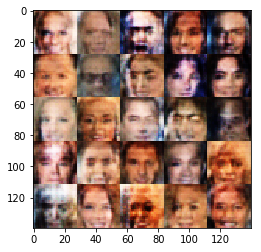

Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.4782
Epoch 1/1... Discriminator Loss: 1.9527... Generator Loss: 0.2067
Epoch 1/1... Discriminator Loss: 1.0315... Generator Loss: 0.8247
Epoch 1/1... Discriminator Loss: 1.1359... Generator Loss: 0.8838
Epoch 1/1... Discriminator Loss: 1.1595... Generator Loss: 0.9727
Epoch 1/1... Discriminator Loss: 1.1926... Generator Loss: 0.6486
Epoch 1/1... Discriminator Loss: 1.3296... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 1.2647... Generator Loss: 0.9248
Epoch 1/1... Discriminator Loss: 1.4570... Generator Loss: 0.5697
Epoch 1/1... Discriminator Loss: 1.5195... Generator Loss: 0.4393


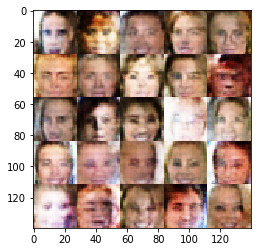

Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 0.6872
Epoch 1/1... Discriminator Loss: 1.1815... Generator Loss: 0.7028
Epoch 1/1... Discriminator Loss: 1.3390... Generator Loss: 0.5408
Epoch 1/1... Discriminator Loss: 1.3185... Generator Loss: 0.6145
Epoch 1/1... Discriminator Loss: 1.6127... Generator Loss: 0.5470
Epoch 1/1... Discriminator Loss: 1.2403... Generator Loss: 1.0490
Epoch 1/1... Discriminator Loss: 1.2149... Generator Loss: 0.7059
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 1.4511... Generator Loss: 0.5472
Epoch 1/1... Discriminator Loss: 1.0751... Generator Loss: 1.0656


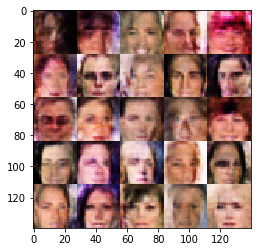

Epoch 1/1... Discriminator Loss: 1.2084... Generator Loss: 0.9557
Epoch 1/1... Discriminator Loss: 1.1225... Generator Loss: 0.7802
Epoch 1/1... Discriminator Loss: 1.3140... Generator Loss: 0.6713
Epoch 1/1... Discriminator Loss: 1.2667... Generator Loss: 0.6149
Epoch 1/1... Discriminator Loss: 1.2185... Generator Loss: 0.8773
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.5796
Epoch 1/1... Discriminator Loss: 1.1643... Generator Loss: 0.8897
Epoch 1/1... Discriminator Loss: 1.1951... Generator Loss: 0.8179
Epoch 1/1... Discriminator Loss: 1.2272... Generator Loss: 0.8277
Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.7544


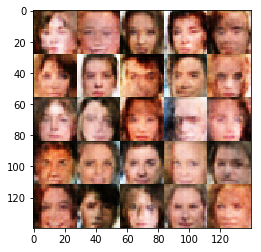

Epoch 1/1... Discriminator Loss: 1.1349... Generator Loss: 0.9232
Epoch 1/1... Discriminator Loss: 1.1527... Generator Loss: 0.7010
Epoch 1/1... Discriminator Loss: 1.2096... Generator Loss: 0.6704
Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 0.5437
Epoch 1/1... Discriminator Loss: 1.2433... Generator Loss: 0.6574
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.5447
Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 0.8989
Epoch 1/1... Discriminator Loss: 1.3364... Generator Loss: 0.6459
Epoch 1/1... Discriminator Loss: 1.1145... Generator Loss: 0.9569
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.5241


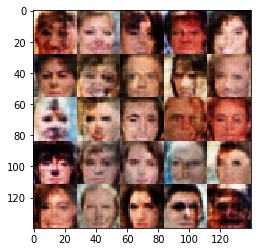

Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.7857
Epoch 1/1... Discriminator Loss: 0.9959... Generator Loss: 1.0920
Epoch 1/1... Discriminator Loss: 1.1753... Generator Loss: 0.7170
Epoch 1/1... Discriminator Loss: 1.2217... Generator Loss: 0.7160
Epoch 1/1... Discriminator Loss: 1.1581... Generator Loss: 1.2990
Epoch 1/1... Discriminator Loss: 1.1224... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.8788
Epoch 1/1... Discriminator Loss: 1.3193... Generator Loss: 0.6287
Epoch 1/1... Discriminator Loss: 1.2743... Generator Loss: 0.6821
Epoch 1/1... Discriminator Loss: 1.2631... Generator Loss: 0.9527


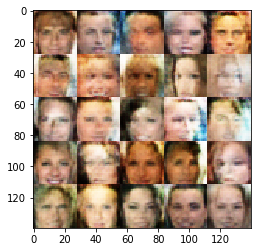

Epoch 1/1... Discriminator Loss: 1.0247... Generator Loss: 1.0167
Epoch 1/1... Discriminator Loss: 1.2038... Generator Loss: 0.7323
Epoch 1/1... Discriminator Loss: 1.1840... Generator Loss: 0.5663
Epoch 1/1... Discriminator Loss: 1.2765... Generator Loss: 0.7396
Epoch 1/1... Discriminator Loss: 1.2558... Generator Loss: 0.6972
Epoch 1/1... Discriminator Loss: 1.0741... Generator Loss: 0.7688
Epoch 1/1... Discriminator Loss: 1.0023... Generator Loss: 0.8576
Epoch 1/1... Discriminator Loss: 1.2757... Generator Loss: 0.7993
Epoch 1/1... Discriminator Loss: 1.2952... Generator Loss: 0.7495
Epoch 1/1... Discriminator Loss: 0.9889... Generator Loss: 1.0086


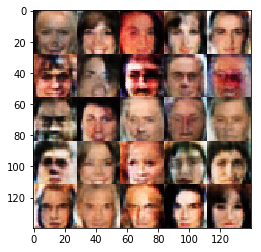

Epoch 1/1... Discriminator Loss: 1.1519... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 0.9642... Generator Loss: 0.9086
Epoch 1/1... Discriminator Loss: 1.2144... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 1.2756... Generator Loss: 0.6489
Epoch 1/1... Discriminator Loss: 1.1568... Generator Loss: 0.7013
Epoch 1/1... Discriminator Loss: 1.1518... Generator Loss: 0.7637
Epoch 1/1... Discriminator Loss: 0.8149... Generator Loss: 1.3238
Epoch 1/1... Discriminator Loss: 1.3121... Generator Loss: 0.6071
Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 0.8122
Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 0.4988


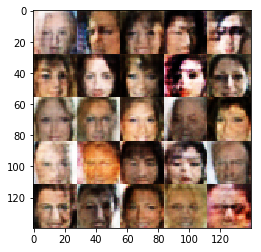

Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 0.9141
Epoch 1/1... Discriminator Loss: 1.1547... Generator Loss: 1.1072
Epoch 1/1... Discriminator Loss: 1.3154... Generator Loss: 0.6240
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.7251
Epoch 1/1... Discriminator Loss: 1.1617... Generator Loss: 1.0023
Epoch 1/1... Discriminator Loss: 1.1848... Generator Loss: 0.6456
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 0.5223
Epoch 1/1... Discriminator Loss: 1.1936... Generator Loss: 0.8849
Epoch 1/1... Discriminator Loss: 1.0932... Generator Loss: 0.7717
Epoch 1/1... Discriminator Loss: 1.2007... Generator Loss: 0.8401


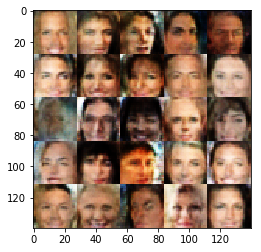

Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.4991
Epoch 1/1... Discriminator Loss: 1.3455... Generator Loss: 0.6619
Epoch 1/1... Discriminator Loss: 1.1718... Generator Loss: 1.0820
Epoch 1/1... Discriminator Loss: 1.3167... Generator Loss: 0.5844
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.4184
Epoch 1/1... Discriminator Loss: 1.1687... Generator Loss: 0.6231
Epoch 1/1... Discriminator Loss: 1.5009... Generator Loss: 0.3858
Epoch 1/1... Discriminator Loss: 1.2654... Generator Loss: 1.0509
Epoch 1/1... Discriminator Loss: 1.5877... Generator Loss: 0.5159
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.5879


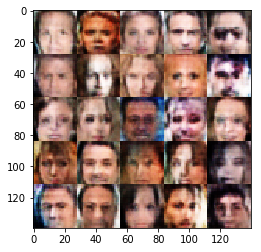

Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 0.5371
Epoch 1/1... Discriminator Loss: 1.2157... Generator Loss: 0.8293
Epoch 1/1... Discriminator Loss: 0.9456... Generator Loss: 1.0555
Epoch 1/1... Discriminator Loss: 1.2543... Generator Loss: 0.5609
Epoch 1/1... Discriminator Loss: 1.4863... Generator Loss: 0.3921
Epoch 1/1... Discriminator Loss: 1.1467... Generator Loss: 0.9230
Epoch 1/1... Discriminator Loss: 1.2660... Generator Loss: 0.5703
Epoch 1/1... Discriminator Loss: 0.7961... Generator Loss: 1.5032
Epoch 1/1... Discriminator Loss: 1.1919... Generator Loss: 1.0538
Epoch 1/1... Discriminator Loss: 1.0316... Generator Loss: 0.9380


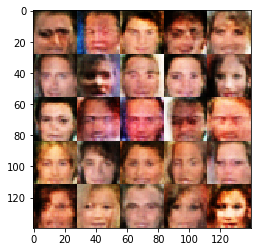

Epoch 1/1... Discriminator Loss: 1.0645... Generator Loss: 0.9007
Epoch 1/1... Discriminator Loss: 1.5389... Generator Loss: 0.3705
Epoch 1/1... Discriminator Loss: 1.0475... Generator Loss: 0.9518
Epoch 1/1... Discriminator Loss: 1.0701... Generator Loss: 0.7021
Epoch 1/1... Discriminator Loss: 1.2864... Generator Loss: 0.5423
Epoch 1/1... Discriminator Loss: 1.1940... Generator Loss: 0.9383
Epoch 1/1... Discriminator Loss: 1.1742... Generator Loss: 0.8017
Epoch 1/1... Discriminator Loss: 1.3175... Generator Loss: 0.5254
Epoch 1/1... Discriminator Loss: 1.1691... Generator Loss: 0.7040
Epoch 1/1... Discriminator Loss: 1.2002... Generator Loss: 0.6611


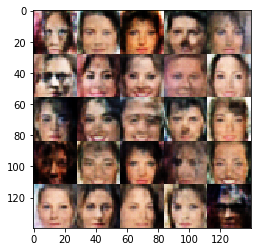

Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 0.4630
Epoch 1/1... Discriminator Loss: 1.0163... Generator Loss: 1.2187
Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.5611
Epoch 1/1... Discriminator Loss: 1.4415... Generator Loss: 0.4737
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.5484
Epoch 1/1... Discriminator Loss: 1.1527... Generator Loss: 0.7253
Epoch 1/1... Discriminator Loss: 1.0605... Generator Loss: 0.8706
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.6387
Epoch 1/1... Discriminator Loss: 1.1363... Generator Loss: 1.1271
Epoch 1/1... Discriminator Loss: 1.1910... Generator Loss: 0.6009


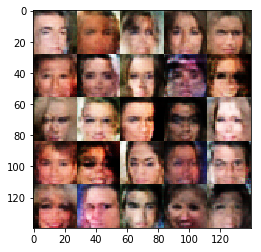

Epoch 1/1... Discriminator Loss: 0.9336... Generator Loss: 1.0066
Epoch 1/1... Discriminator Loss: 1.3374... Generator Loss: 0.5140
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.8303
Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.5685
Epoch 1/1... Discriminator Loss: 1.3099... Generator Loss: 0.7049
Epoch 1/1... Discriminator Loss: 1.0122... Generator Loss: 1.1295
Epoch 1/1... Discriminator Loss: 1.1174... Generator Loss: 0.9913
Epoch 1/1... Discriminator Loss: 1.0553... Generator Loss: 0.8472
Epoch 1/1... Discriminator Loss: 1.2662... Generator Loss: 0.7905
Epoch 1/1... Discriminator Loss: 1.1675... Generator Loss: 0.5536


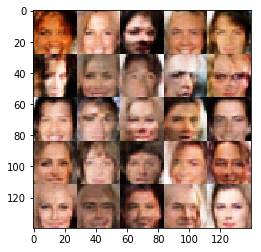

Epoch 1/1... Discriminator Loss: 1.0304... Generator Loss: 0.9960
Epoch 1/1... Discriminator Loss: 0.9042... Generator Loss: 1.1377
Epoch 1/1... Discriminator Loss: 1.2880... Generator Loss: 0.4884
Epoch 1/1... Discriminator Loss: 1.1153... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 0.9640... Generator Loss: 1.0081
Epoch 1/1... Discriminator Loss: 1.2477... Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 1.0984... Generator Loss: 1.1286
Epoch 1/1... Discriminator Loss: 1.2430... Generator Loss: 0.6799
Epoch 1/1... Discriminator Loss: 1.0943... Generator Loss: 0.9554
Epoch 1/1... Discriminator Loss: 1.0874... Generator Loss: 0.7967


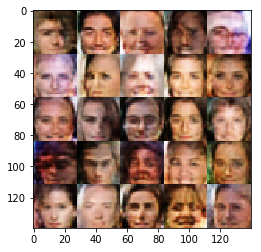

Epoch 1/1... Discriminator Loss: 1.2042... Generator Loss: 0.6264
Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 0.4915
Epoch 1/1... Discriminator Loss: 1.0370... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 1.5862... Generator Loss: 0.3730
Epoch 1/1... Discriminator Loss: 1.1582... Generator Loss: 0.7019
Epoch 1/1... Discriminator Loss: 1.2056... Generator Loss: 0.8235
Epoch 1/1... Discriminator Loss: 0.9838... Generator Loss: 0.9320
Epoch 1/1... Discriminator Loss: 1.1113... Generator Loss: 0.6992
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.9009
Epoch 1/1... Discriminator Loss: 1.1520... Generator Loss: 0.8219


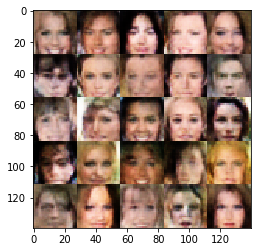

Epoch 1/1... Discriminator Loss: 1.2472... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.2685... Generator Loss: 0.6707
Epoch 1/1... Discriminator Loss: 1.0059... Generator Loss: 0.7533
Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.5853
Epoch 1/1... Discriminator Loss: 1.1459... Generator Loss: 0.8792
Epoch 1/1... Discriminator Loss: 1.3216... Generator Loss: 0.4867


In [27]:
# This model works the best with the lowest g_loss and d_loss values

batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

Epoch 1/1... Discriminator Loss: 2.1557... Generator Loss: 0.3725
Epoch 1/1... Discriminator Loss: 1.2878... Generator Loss: 0.6932
Epoch 1/1... Discriminator Loss: 0.9038... Generator Loss: 1.3948
Epoch 1/1... Discriminator Loss: 0.5618... Generator Loss: 3.3951
Epoch 1/1... Discriminator Loss: 2.1841... Generator Loss: 0.1736
Epoch 1/1... Discriminator Loss: 1.0830... Generator Loss: 0.9694
Epoch 1/1... Discriminator Loss: 1.0706... Generator Loss: 0.8868
Epoch 1/1... Discriminator Loss: 1.0930... Generator Loss: 0.8248
Epoch 1/1... Discriminator Loss: 1.0138... Generator Loss: 1.9688
Epoch 1/1... Discriminator Loss: 1.5627... Generator Loss: 0.4794


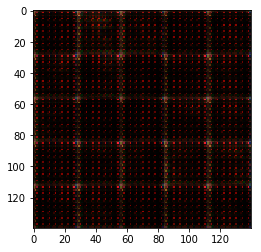

Epoch 1/1... Discriminator Loss: 1.1455... Generator Loss: 0.7341
Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.4392
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.6714
Epoch 1/1... Discriminator Loss: 1.6187... Generator Loss: 0.4073
Epoch 1/1... Discriminator Loss: 1.1467... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 1.5145... Generator Loss: 0.5203
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 1.0041
Epoch 1/1... Discriminator Loss: 1.5571... Generator Loss: 0.4038
Epoch 1/1... Discriminator Loss: 0.9387... Generator Loss: 1.0796
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.8934


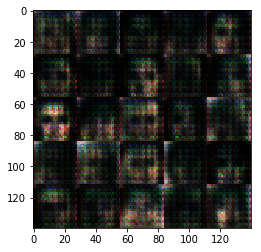

Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.7763
Epoch 1/1... Discriminator Loss: 1.4572... Generator Loss: 0.4834
Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 0.6414
Epoch 1/1... Discriminator Loss: 1.1368... Generator Loss: 0.8490
Epoch 1/1... Discriminator Loss: 1.2413... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 1.2239... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 1.1023
Epoch 1/1... Discriminator Loss: 1.5694... Generator Loss: 0.6405
Epoch 1/1... Discriminator Loss: 1.5411... Generator Loss: 0.4953
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.7064


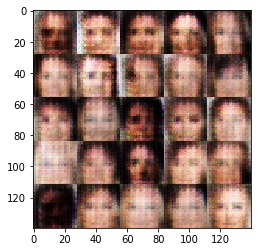

Epoch 1/1... Discriminator Loss: 1.3388... Generator Loss: 0.8560
Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.7193
Epoch 1/1... Discriminator Loss: 1.1965... Generator Loss: 0.8164
Epoch 1/1... Discriminator Loss: 1.5334... Generator Loss: 0.6159
Epoch 1/1... Discriminator Loss: 1.5814... Generator Loss: 0.6880
Epoch 1/1... Discriminator Loss: 1.2616... Generator Loss: 0.8948
Epoch 1/1... Discriminator Loss: 1.5205... Generator Loss: 0.8040
Epoch 1/1... Discriminator Loss: 1.5767... Generator Loss: 0.6436
Epoch 1/1... Discriminator Loss: 1.2871... Generator Loss: 0.8898
Epoch 1/1... Discriminator Loss: 1.2927... Generator Loss: 0.6111


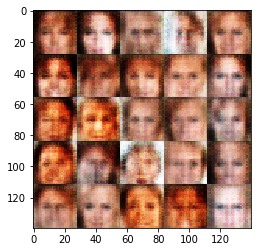

Epoch 1/1... Discriminator Loss: 1.1927... Generator Loss: 0.7860
Epoch 1/1... Discriminator Loss: 1.6530... Generator Loss: 0.5986
Epoch 1/1... Discriminator Loss: 1.5286... Generator Loss: 0.5966
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.7392
Epoch 1/1... Discriminator Loss: 1.5042... Generator Loss: 0.6201
Epoch 1/1... Discriminator Loss: 1.5325... Generator Loss: 0.9123
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.5861
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 1.0542
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.6799
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.8150


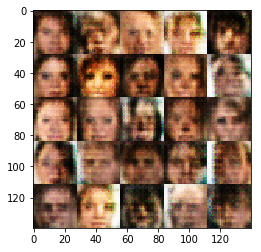

Epoch 1/1... Discriminator Loss: 1.2078... Generator Loss: 0.8327
Epoch 1/1... Discriminator Loss: 1.4625... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.6068
Epoch 1/1... Discriminator Loss: 1.2532... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.8120
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 1.5145... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.6674
Epoch 1/1... Discriminator Loss: 1.4749... Generator Loss: 0.7518
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.6875


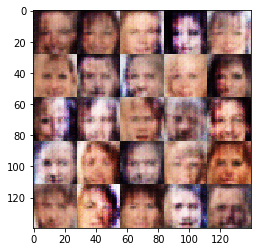

Epoch 1/1... Discriminator Loss: 1.3593... Generator Loss: 0.8022
Epoch 1/1... Discriminator Loss: 1.3425... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.7231
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.8100
Epoch 1/1... Discriminator Loss: 1.3016... Generator Loss: 0.7702
Epoch 1/1... Discriminator Loss: 1.3037... Generator Loss: 0.8326
Epoch 1/1... Discriminator Loss: 1.3142... Generator Loss: 0.7259
Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.5895
Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.8282
Epoch 1/1... Discriminator Loss: 1.4863... Generator Loss: 0.5504


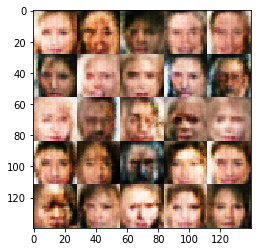

Epoch 1/1... Discriminator Loss: 1.3011... Generator Loss: 0.8128
Epoch 1/1... Discriminator Loss: 1.3056... Generator Loss: 0.7579
Epoch 1/1... Discriminator Loss: 1.3424... Generator Loss: 0.8978
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.5770
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 0.7957
Epoch 1/1... Discriminator Loss: 1.4395... Generator Loss: 0.6477
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.6705
Epoch 1/1... Discriminator Loss: 1.2980... Generator Loss: 0.8049
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.7695
Epoch 1/1... Discriminator Loss: 1.1619... Generator Loss: 0.8031


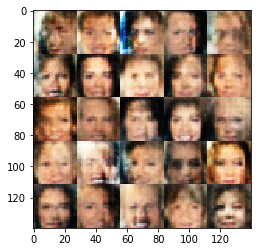

Epoch 1/1... Discriminator Loss: 1.2824... Generator Loss: 0.7305
Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.5561
Epoch 1/1... Discriminator Loss: 1.2849... Generator Loss: 0.7159
Epoch 1/1... Discriminator Loss: 1.4424... Generator Loss: 0.7934
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.6561
Epoch 1/1... Discriminator Loss: 1.3555... Generator Loss: 0.8233
Epoch 1/1... Discriminator Loss: 1.4762... Generator Loss: 0.5558
Epoch 1/1... Discriminator Loss: 1.2535... Generator Loss: 0.7823
Epoch 1/1... Discriminator Loss: 1.3439... Generator Loss: 0.7380
Epoch 1/1... Discriminator Loss: 1.2266... Generator Loss: 0.8767


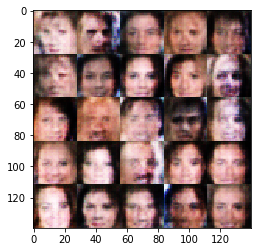

Epoch 1/1... Discriminator Loss: 1.4872... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.6796
Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.6565
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.8151
Epoch 1/1... Discriminator Loss: 1.2964... Generator Loss: 0.8662
Epoch 1/1... Discriminator Loss: 1.3283... Generator Loss: 0.7618
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.8248
Epoch 1/1... Discriminator Loss: 1.2990... Generator Loss: 0.6993
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.9023
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.6974


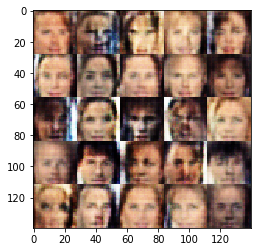

Epoch 1/1... Discriminator Loss: 1.2714... Generator Loss: 0.9315
Epoch 1/1... Discriminator Loss: 1.2781... Generator Loss: 0.6904
Epoch 1/1... Discriminator Loss: 1.2645... Generator Loss: 0.6850
Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 0.8157
Epoch 1/1... Discriminator Loss: 1.3371... Generator Loss: 0.8155
Epoch 1/1... Discriminator Loss: 1.2779... Generator Loss: 0.9848
Epoch 1/1... Discriminator Loss: 1.2395... Generator Loss: 0.8553
Epoch 1/1... Discriminator Loss: 1.1726... Generator Loss: 0.8068
Epoch 1/1... Discriminator Loss: 1.4748... Generator Loss: 0.4598
Epoch 1/1... Discriminator Loss: 1.2113... Generator Loss: 0.7331


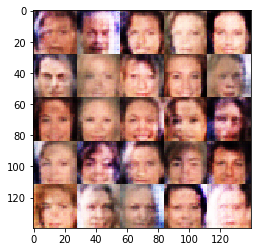

Epoch 1/1... Discriminator Loss: 1.3349... Generator Loss: 0.8567
Epoch 1/1... Discriminator Loss: 1.2384... Generator Loss: 0.9447
Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 1.1778
Epoch 1/1... Discriminator Loss: 1.2408... Generator Loss: 0.8520
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.7259
Epoch 1/1... Discriminator Loss: 1.1388... Generator Loss: 0.8505
Epoch 1/1... Discriminator Loss: 1.1299... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 1.2812... Generator Loss: 1.1031
Epoch 1/1... Discriminator Loss: 1.1776... Generator Loss: 0.9949
Epoch 1/1... Discriminator Loss: 1.2174... Generator Loss: 0.8962


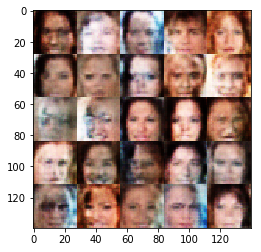

Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.7713
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.5498
Epoch 1/1... Discriminator Loss: 1.3091... Generator Loss: 0.8098
Epoch 1/1... Discriminator Loss: 1.3445... Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 1.2382... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.8214
Epoch 1/1... Discriminator Loss: 1.6469... Generator Loss: 0.5552
Epoch 1/1... Discriminator Loss: 1.6182... Generator Loss: 0.7150
Epoch 1/1... Discriminator Loss: 1.6254... Generator Loss: 0.5485
Epoch 1/1... Discriminator Loss: 1.5482... Generator Loss: 0.7974


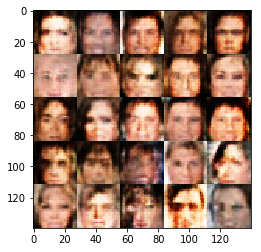

Epoch 1/1... Discriminator Loss: 1.2352... Generator Loss: 0.8135
Epoch 1/1... Discriminator Loss: 1.3370... Generator Loss: 0.6748
Epoch 1/1... Discriminator Loss: 1.1818... Generator Loss: 0.9049
Epoch 1/1... Discriminator Loss: 1.3160... Generator Loss: 0.8907
Epoch 1/1... Discriminator Loss: 1.2518... Generator Loss: 0.6933
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.6681
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.8885
Epoch 1/1... Discriminator Loss: 1.5023... Generator Loss: 0.6297
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.8235


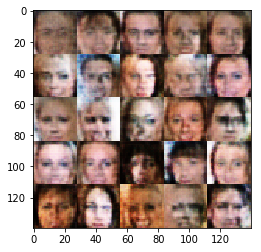

Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.6695
Epoch 1/1... Discriminator Loss: 1.2031... Generator Loss: 0.9767
Epoch 1/1... Discriminator Loss: 1.2249... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 1.2643... Generator Loss: 0.7262
Epoch 1/1... Discriminator Loss: 1.2168... Generator Loss: 0.8545
Epoch 1/1... Discriminator Loss: 1.0955... Generator Loss: 0.9541
Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 0.6361
Epoch 1/1... Discriminator Loss: 1.1953... Generator Loss: 0.9575
Epoch 1/1... Discriminator Loss: 1.2214... Generator Loss: 0.8169


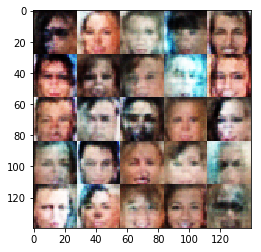

Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 1.1692
Epoch 1/1... Discriminator Loss: 1.2168... Generator Loss: 0.8137
Epoch 1/1... Discriminator Loss: 1.4808... Generator Loss: 0.5683
Epoch 1/1... Discriminator Loss: 1.3044... Generator Loss: 0.9014
Epoch 1/1... Discriminator Loss: 1.1032... Generator Loss: 1.2657
Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 0.9283
Epoch 1/1... Discriminator Loss: 1.2666... Generator Loss: 0.7434
Epoch 1/1... Discriminator Loss: 1.1849... Generator Loss: 0.8366


In [19]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.